In [5]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import stop_words
import pprint
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [6]:
#Read data from CSVs
def fetch_grid():
    train = pd.read_csv('./data/domain_classification/train_data.csv',encoding='UTF-8')
    test = pd.read_csv('./data/domain_classification/test_data.csv',encoding='UTF-8')
    return train, test

train_haptik, test_haptik = fetch_grid()
train_haptik.head()
test_haptik.head()

,message,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,Nearest metro station,F,F,F,F,F,T,F,F,F
1,Pick up n drop service trough cab,F,F,F,F,T,F,F,F,F
2,I wants to buy a bick,F,F,F,F,F,F,F,F,T
3,Show me pizza,T,F,F,F,F,F,F,F,F
4,What is the cheapest package to andaman and ni...,F,F,F,F,T,F,F,F,F


In [7]:
#Separate features from target variables.
def feature_target_separator(df):
    ftr = pd.DataFrame(df,columns=['message'])
    tgt = pd.DataFrame(df,columns=list( set(df.columns) - set(['message']) ))
    return ftr,tgt

feat,targ = feature_target_separator(train_haptik)
print targ.info()

feat_ts,targ_ts = feature_target_separator(test_haptik)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40659 entries, 0 to 40658
Data columns (total 9 columns):
food         40659 non-null object
travel       40659 non-null object
support      40659 non-null object
reminders    40659 non-null object
movies       40659 non-null object
other        40659 non-null object
recharge     40659 non-null object
casual       40659 non-null object
nearby       40659 non-null object
dtypes: object(9)
memory usage: 2.8+ MB
None


In [8]:
#Used to convert all T and Fs to 1 and 0s
def pre_OHE(n):
    if n =='T':
        return 1
    else:
        return 0

In [9]:
#Converts all T/F to 1 and 0
def conv(targ):
    for col in targ.columns:
        targ[col] = targ[col].apply(pre_OHE)
    return targ

t_targ = conv(targ)
ts_targ = conv(targ_ts)
len(t_targ)

40659

In [10]:
#Removes all rows where more than one category is true 
def truncate_target_df(df):
    df = pd.DataFrame(df[df.sum(axis=1) == 1])
    return df

t_targ = truncate_target_df(t_targ)
ts_targ = truncate_target_df(ts_targ)
# t_targ = pd.DataFrame(targ[targ.sum(axis=1) == 1])
# ts_targ = pd.DataFrame(ts_targ[ts_targ.sum(axis=1)==1])
len(t_targ)

36993

In [11]:
#reverses OHE to get a Series of categories
def reverse_OHE(df):
    ret_df = df.idxmax(1)
    return ret_df

fin_targ = reverse_OHE(t_targ)
fin_ts_targ = reverse_OHE(ts_targ)    

In [12]:
#Create final dataframe using message and category columns

fin_targ = pd.DataFrame(fin_targ,columns=['category'])
fin_ts_targ = pd.DataFrame(fin_ts_targ,columns=['category'])

fin_train = pd.DataFrame(train_haptik,index=fin_targ.index,columns=['message'])
fin_ts_train = pd.DataFrame(test_haptik,index=fin_ts_targ.index,columns=['message'])

print(len(fin_train),len(fin_targ))

final = pd.concat([fin_train,fin_targ],axis=1)
final_ts = pd.concat([fin_ts_train,fin_ts_targ],axis=1)

print len(fin_train),len(fin_targ)
print len(fin_ts_train),len(fin_ts_targ)
print final_ts.head(3)

(36993, 36993)
36993 36993
9492 9492
                             message category
0              Nearest metro station   nearby
1  Pick up n drop service trough cab   travel
2              I wants to buy a bick    other


314519
24880
24871


,freq
train,1.00
pnr,0.96
6e,0.96
30pm,0.88
time,0.88
travel,0.76
ok,0.72
mr,0.68
30am,0.68
offer,0.64


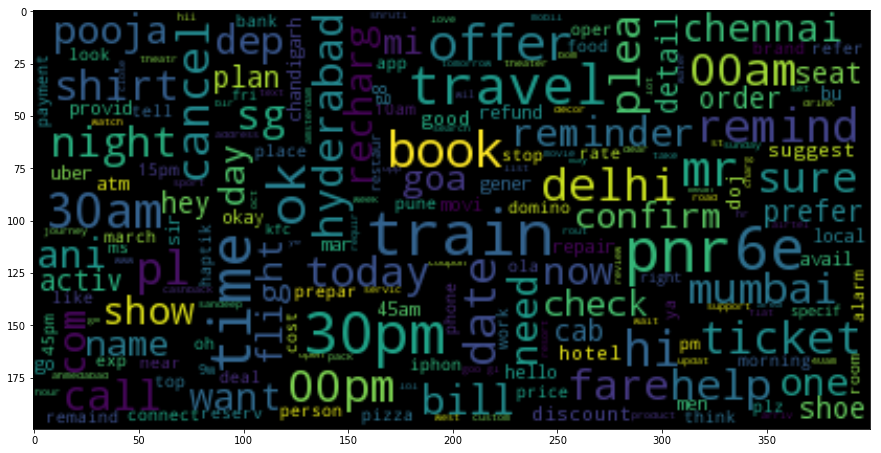

In [13]:
#Attempts to create a wordcloud. Also returns a set of stopwords
def wordcloud(df):
    df_ls = df.values.tolist()
    tk = TreebankWordTokenizer()
    tokens = []
    sw2 = []
    
    for row in df_ls:
        tokens.extend(tk.tokenize(row[0]))
        
    sw = stop_words.get_stop_words('english')
    sw2.extend([unicode('rs'),unicode('can'),unicode('thanks'),unicode('thank'),unicode('task'),unicode('api_name'),unicode('trains_api'),unicode('product_id'),unicode('please')])
    #sw2.extend([unicode('rs'),unicode('can'),unicode('thanks'),unicode('thank'),unicode('task')])
    sw2.extend(sw)
    
    print len(tokens)
    print len(set(tokens).difference(set(sw)))
    
    tk_sw = set(tokens).difference(set(sw2))
    ps = PorterStemmer()
    tk_sw_st = []
    
    for e in tk_sw:
        tmp_str = e.replace(u'\t',' ')
        tk_sw_st.append(ps.stem(tmp_str))
    
    fin_str = " ".join(tk_sw_st)
    sw_3 = [x.encode('utf-8') for x in sw2]
    print len(tk_sw_st)
    wc = WordCloud(stopwords=sw_3,max_font_size=30).generate(fin_str)
    plt.figure(figsize=(15,15))
    plt.imshow(wc,interpolation='bilinear') 
    word_freq = pd.DataFrame(wc.words_.values(), index = wc.words_.keys())
    return sw_3,word_freq

sw2, words = wordcloud(feat)
##print sw2        
words.rename(columns= {0:'freq'}, inplace=True)
words.sort_values(by = 'freq', ascending = False)

In [14]:
#Create vectorizer objects,shuffle dataframe, separate X and Y and create TDMs.
tk = TreebankWordTokenizer()

#vect = CountVectorizer(stop_words=sw2,ngram_range=(1,2),tokenizer=tk.tokenize,min_df=4,max_df=0.2)
vect = CountVectorizer(stop_words=sw2,ngram_range=(1,2),tokenizer=tk.tokenize)
vect2 = TfidfVectorizer(ngram_range=(1,2),tokenizer=tk.tokenize,min_df=4,max_df=0.2,norm='l1')

#tsvd = TruncatedSVD(n_components=1000, random_state=100)

final = final.sample(frac=1)
final_ts = final_ts.sample(frac=1)

x_train = pd.DataFrame(final,columns=['message'])
y_train = pd.DataFrame(final,columns=['category'])

#print x_train.head(5)
#print y_train.head(5)

x_test = pd.DataFrame(final_ts,columns=['message'])
y_test = pd.DataFrame(final_ts,columns=['category'])

ser1 = pd.Series(x_train['message'])
ser2 = pd.Series(y_train['category'])

ser1_ts = pd.Series(x_test['message'])
ser2_ts = pd.Series(y_test['category'])

#print ser2_ts.head(5)

vect.fit(ser1)
vect2.fit(ser1)

dtm = vect.transform(ser1)
dtm2 = vect2.transform(ser1)

#tsvd.fit(dtm)
#dtm_svd = tsvd.transform(dtm)

print(dtm.shape)
#print(dtm_svd.shape)
print(dtm2.shape)

(36993, 101858)
(36993, 11205)


In [15]:
len(vect.get_feature_names())

101858

In [16]:
#vect

In [17]:
dtm_svd = map(np.absolute,dtm_svd)

NameError: name 'dtm_svd' is not defined

In [18]:
#Perform label-encoding on category columns
le = LabelEncoder()
le.fit_transform(ser2)
le.fit_transform(ser2_ts)

array([0, 7, 0, ..., 4, 4, 2])

In [19]:
#Fit classifier on TDM. dtm = CountVectorizer, dtm2 = TfidfVectorizer
nb = MultinomialNB(alpha=0.25,fit_prior=False)
nb_t = MultinomialNB(alpha=0.25,fit_prior=False)

nb.fit(dtm,ser2)
nb_t.fit(dtm2,ser2)

MultinomialNB(alpha=0.25, class_prior=None, fit_prior=False)

In [21]:
#Transform test X to TDM.
test_dtm = vect.transform(ser1_ts)
test_dtm2 = vect2.transform(ser1_ts)

#test_dtm_svd = tsvd.transform(test_dtm)
#test_dtm_svd = map(np.absolute,test_dtm_svd)

In [23]:
#Predict category columns.Uses CountVectorizer.
y_pred = nb.predict(test_dtm)
print metrics.accuracy_score(ser2_ts,y_pred)
print cross_val_score(nb,test_dtm,ser2_ts,cv=10)

0.817214496418
[ 0.81951731  0.80377754  0.79390116  0.8113804   0.80084299  0.81540084
  0.79113924  0.80696203  0.80485232  0.8031746 ]


In [24]:
#Predict category columns.Uses TfidfVectorizer.
y_pred_t = nb_t.predict(test_dtm2)
print metrics.accuracy_score(ser2_ts,y_pred_t)
print cross_val_score(nb_t,test_dtm2,ser2_ts,cv=10)

0.821428571429
[ 0.82791186  0.80482686  0.79495268  0.83034773  0.8061117   0.8164557
  0.7943038   0.80907173  0.8164557   0.82539683]


In [25]:
#Prints confusion matrix and classification report.
cr = classification_report(ser2_ts,y_pred)
cr_t = classification_report(ser2_ts,y_pred_t)
print cr
print cr_t
print confusion_matrix(ser2_ts,y_pred)
print ('\n')
print confusion_matrix(ser2_ts,y_pred_t)

             precision    recall  f1-score   support

     casual       0.88      0.80      0.84      3242
       food       0.83      0.89      0.86       542
     movies       0.77      0.78      0.78       433
     nearby       0.64      0.78      0.70       645
      other       0.87      0.71      0.78      1619
   recharge       0.62      0.92      0.74       240
  reminders       0.89      0.84      0.86       823
    support       0.61      0.68      0.64       199
     travel       0.80      0.93      0.86      1749

avg / total       0.83      0.82      0.82      9492

             precision    recall  f1-score   support

     casual       0.87      0.84      0.85      3242
       food       0.83      0.85      0.84       542
     movies       0.82      0.77      0.79       433
     nearby       0.66      0.76      0.71       645
      other       0.84      0.71      0.77      1619
   recharge       0.59      0.88      0.71       240
  reminders       0.84      0.87      0.85

In [ ]:
[ lambda x:x*x  for x in range(10) ]